In [1]:
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    GlueDataset,
    GlueDataTrainingArguments,
    Trainer,
    TrainingArguments,
    default_data_collator,
    glue_compute_metrics,
    glue_output_modes)
from influence_utils.utils_hans import HansDataset

import torch
import numpy as np
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.sampler import RandomSampler, SequentialSampler
from influence_utils.influence import compute_s_test
from influence_utils import glue_utils

In [2]:
# dir_name = "/export/home/Experiments/20200708/MNLI_data/remove_100_harmful/output_dir/"

In [3]:
from glob import glob
from collections import defaultdict
glob("/export/home/Experiments/20200708/MNLI_data/remove_*/output_dir/") + ["/export/home/Experiments/20200706/"]

['/export/home/Experiments/20200708/MNLI_data/remove_100_random/output_dir/',
 '/export/home/Experiments/20200708/MNLI_data/remove_100_helpful/output_dir/',
 '/export/home/Experiments/20200708/MNLI_data/remove_100_harmful/output_dir/',
 '/export/home/Experiments/20200708/MNLI_data/remove_20_helpful/output_dir/',
 '/export/home/Experiments/20200708/MNLI_data/remove_1_harmful/output_dir/',
 '/export/home/Experiments/20200708/MNLI_data/remove_1_helpful/output_dir/',
 '/export/home/Experiments/20200708/MNLI_data/remove_1_random/output_dir/',
 '/export/home/Experiments/20200708/MNLI_data/remove_20_random/output_dir/',
 '/export/home/Experiments/20200708/MNLI_data/remove_20_harmful/output_dir/',
 '/export/home/Experiments/20200706/']

In [4]:
output_collections = defaultdict(dict)
for dir_name in glob("/export/home/Experiments/20200708/MNLI_data/remove_*/output_dir/") + ["/export/home/Experiments/20200706/"]:
    tokenizer = AutoTokenizer.from_pretrained(dir_name)
    model = AutoModelForSequenceClassification.from_pretrained(dir_name)
    model.eval()

    train_dataset = GlueDataset(
        args=GlueDataTrainingArguments(
            task_name="mnli",
            max_seq_length=128,
            data_dir="/export/home/Data/Glue/MNLI/"),
        tokenizer=tokenizer)

    eval_dataset = GlueDataset(
        args=GlueDataTrainingArguments(
            task_name="mnli",
            max_seq_length=128,
            data_dir="/export/home/Data/Glue/MNLI/"),
        tokenizer=tokenizer,
        mode="dev")


    def hans_data_collator(features):
        """
        Data collator that removes the "pairID" key if present.
        """
        batch = default_data_collator(features)
        _ = batch.pop("pairID", None)
        return batch


    def get_dataloader(dataset, batch_size, data_collator) -> DataLoader:
        sampler = SequentialSampler(dataset)

        data_loader = DataLoader(
            dataset,
            sampler=sampler,
            batch_size=batch_size,
            collate_fn=data_collator,
        )

        return data_loader


    def decode_one_example(inputs, logits=None):
        if inputs["input_ids"].shape[0] != 1:
            raise ValueError

        X = tokenizer.decode(inputs["input_ids"][0])
        Y = train_dataset.label_list[inputs["labels"].item()]
        if logits is not None:
            Y_hat = train_dataset.label_list[
                logits.argmax(dim=-1).item()]
            return X, Y, Y_hat
        else:
            return X, Y

    output_mode = glue_output_modes["mnli"]
    def build_compute_metrics_fn(task_name: str):
        def compute_metrics_fn(p):
            if output_mode == "classification":
                preds = np.argmax(p.predictions, axis=1)
            elif output_mode == "regression":
                preds = np.squeeze(p.predictions)
            return glue_compute_metrics(task_name, preds, p.label_ids)

        return compute_metrics_fn


    trainer = Trainer(
        model=model,
        args=TrainingArguments(output_dir="./tmp-output", per_device_train_batch_size=128, per_device_eval_batch_size=128, learning_rate=5e-5, logging_steps=100),
        data_collator=hans_data_collator,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        compute_metrics=build_compute_metrics_fn("mnli"),
    )

    train_batch_data_loader = get_dataloader(
        train_dataset,
        batch_size=160,
        data_collator=hans_data_collator)

    train_instance_data_loader = get_dataloader(
        train_dataset,
        batch_size=1,
        data_collator=hans_data_collator)

    eval_instance_data_loader = get_dataloader(
        eval_dataset,
        batch_size=1,
        data_collator=hans_data_collator)


    def run_forward(model, inputs):
        # Implicitly used trainer and model
        has_labels = any(inputs.get(k) is not None for k in ["labels", "lm_labels", "masked_lm_labels"])

        for k, v in inputs.items():
            if isinstance(v, torch.Tensor):
                inputs[k] = v.to(trainer.args.device)
        if trainer.args.past_index >= 0:
            inputs["mems"] = past

        with torch.no_grad():
            outputs = model(**inputs)
            if has_labels:
                step_eval_loss, logits = outputs[:2]
                return step_eval_loss, logits
            else:
                logits = outputs[0]
                return logits


    def visualize(inputs):
        X, Y = decode_one_example(inputs)
        premise, hypothesis = X.split("[CLS]")[1].split("[SEP]")[:2]
        print(f"\tP: {premise.strip()}\n\tH: {hypothesis.strip()}\n\tL: {Y}")
        
        
    for i, test_inputs in enumerate(eval_instance_data_loader):
        step_eval_loss, logits = run_forward(model, test_inputs)
        if i == 41:
            break

    print(f"Dirname: {dir_name}")
    print(logits, logits.softmax(dim=-1), step_eval_loss)
    if "20200706" in dir_name:
        for remove_type in ["random", "harmful", "helpful"]:
            output_collections[remove_type][0] = (logits.softmax(dim=-1), step_eval_loss)
    else:
        if "remove_100_random" in dir_name:
            remove_type = "random"
            num_remove = 100
        if "remove_20_random" in dir_name:
            remove_type = "random"
            num_remove = 20
        if "remove_1_random" in dir_name:
            remove_type = "random"
            num_remove = 1
        if "remove_100_harmful" in dir_name:
            remove_type = "harmful"
            num_remove = 100
        if "remove_20_harmful" in dir_name:
            remove_type = "harmful"
            num_remove = 20
        if "remove_1_harmful" in dir_name:
            remove_type = "harmful"
            num_remove = 1
        if "remove_100_helpful" in dir_name:
            remove_type = "helpful"
            num_remove = 100
        if "remove_20_helpful" in dir_name:
            remove_type = "helpful"
            num_remove = 20
        if "remove_1_helpful" in dir_name:
            remove_type = "helpful"
            num_remove = 1
        
        output_collections[remove_type][num_remove] = (logits.softmax(dim=-1), step_eval_loss)

You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.


Dirname: /export/home/Experiments/20200708/MNLI_data/remove_100_random/output_dir/
tensor([[-1.0040,  1.2066, -0.6275]], device='cuda:0') tensor([[0.0864, 0.7878, 0.1259]], device='cuda:0') tensor(2.4491, device='cuda:0')


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.


Dirname: /export/home/Experiments/20200708/MNLI_data/remove_100_helpful/output_dir/
tensor([[-1.7610,  1.6030, -0.5113]], device='cuda:0') tensor([[0.0299, 0.8656, 0.1045]], device='cuda:0') tensor(3.5084, device='cuda:0')


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.


Dirname: /export/home/Experiments/20200708/MNLI_data/remove_100_harmful/output_dir/
tensor([[-0.7497,  0.6718, -0.3156]], device='cuda:0') tensor([[0.1496, 0.6196, 0.2308]], device='cuda:0') tensor(1.9001, device='cuda:0')


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.


Dirname: /export/home/Experiments/20200708/MNLI_data/remove_20_helpful/output_dir/
tensor([[-1.3308,  1.3717, -0.5758]], device='cuda:0') tensor([[0.0554, 0.8267, 0.1179]], device='cuda:0') tensor(2.8928, device='cuda:0')


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.


Dirname: /export/home/Experiments/20200708/MNLI_data/remove_1_harmful/output_dir/
tensor([[-1.1228,  1.1602, -0.6199]], device='cuda:0') tensor([[0.0803, 0.7870, 0.1327]], device='cuda:0') tensor(2.5225, device='cuda:0')


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.


Dirname: /export/home/Experiments/20200708/MNLI_data/remove_1_helpful/output_dir/
tensor([[-1.0725,  1.2105, -0.6713]], device='cuda:0') tensor([[0.0813, 0.7973, 0.1214]], device='cuda:0') tensor(2.5096, device='cuda:0')


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.


Dirname: /export/home/Experiments/20200708/MNLI_data/remove_1_random/output_dir/
tensor([[-1.0991,  1.1363, -0.6035]], device='cuda:0') tensor([[0.0834, 0.7797, 0.1369]], device='cuda:0') tensor(2.4842, device='cuda:0')


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.


Dirname: /export/home/Experiments/20200708/MNLI_data/remove_20_random/output_dir/
tensor([[-1.0223,  1.3247, -0.8949]], device='cuda:0') tensor([[0.0794, 0.8304, 0.0902]], device='cuda:0') tensor(2.5329, device='cuda:0')


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.


Dirname: /export/home/Experiments/20200708/MNLI_data/remove_20_harmful/output_dir/
tensor([[-0.9332,  1.1125, -0.6165]], device='cuda:0') tensor([[0.0989, 0.7653, 0.1358]], device='cuda:0') tensor(2.3132, device='cuda:0')


You are instantiating a Trainer but Tensorboard is not installed. You should consider installing it.


Dirname: /export/home/Experiments/20200706/
tensor([[-1.0180,  1.2213, -0.6772]], device='cuda:0') tensor([[0.0848, 0.7960, 0.1192]], device='cuda:0') tensor(2.4675, device='cuda:0')


In [5]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'Number of data-points removed')

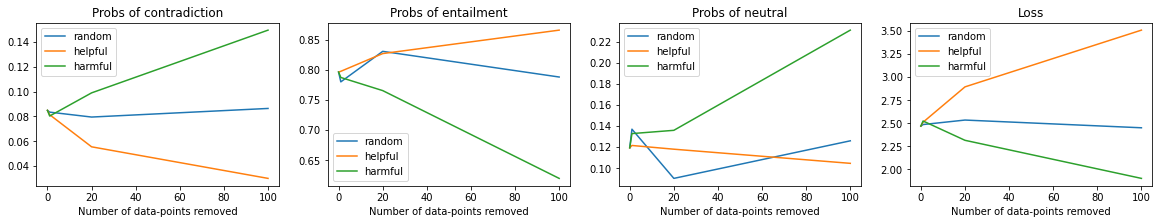

In [6]:
plt.rcParams["figure.figsize"] = (20,3)

for j in range(3):
    plt.subplot(1, 4, j + 1)
    plt.title(f"Probs of {train_dataset.label_list[j]}")
    remove_types = []
    for remove_type in output_collections.keys():
        output_tuple = output_collections[remove_type]
        Y = [output_tuple[0][0].squeeze(dim=0)[j], output_tuple[1][0].squeeze(dim=0)[j], output_tuple[20][0].squeeze(dim=0)[j], output_tuple[100][0].squeeze(dim=0)[j]]
        X = [0, 1, 20, 100]
        plt.plot(X, Y)
        remove_types.append(remove_type)
    plt.legend(remove_types)
    plt.xlabel("Number of data-points removed")
    

plt.subplot(1, 4, 4)
plt.title("Loss")
remove_types = []
for remove_type in output_collections.keys():
    output_tuple = output_collections[remove_type]
    Y = [output_tuple[0][1], output_tuple[1][1], output_tuple[20][1], output_tuple[100][1]]
    X = [0, 1, 20, 100]
    plt.plot(X, Y)
    remove_types.append(remove_type)
plt.legend(remove_types)
plt.xlabel("Number of data-points removed")